Airflow pipeline을 구축하는 방법을 이전에 정리했다.  
### 실제로 해당 실습을 진행하거나 할 때는 이 프로젝트 내의 .ipynb파일을 실행하는 것이 아니라 "/airflow/dags" 안에 .py 형식의 파일로 작성하여야 한다는 것을 유의하자.
이번에는 Spark를 활용하는 pipeline을 정리 및 실습한다.

In [1]:
# 다음 코드로 Airflow에서 Spark를 쓸 수 있도록 해주는 Provider를 설치한다.
!pip install apache-airflow-providers-apache-spark

이전 Spark 실습을 통해 taxi요금을 예측 모델을 학습하던 내용을 현재 파일과 같은 디렉토리에   
preprocess.py, tune_hyperparameter.py, train_model.py로 정리하여 작성해 두었다.  
이를 활용하여 Airflow에서 활용하는 pipeline을 구축하는 것은 다음과 같이 간단하다.

In [ ]:
from datetime import datetime

from airflow import DAG
from airflow.providers.apache.spark.operators.spark_submit import SparkSubmitOperator

default_args = {
  'start_date': datetime(2021, 1, 1),
}

with DAG(dag_id='taxi-price-pipeline',
         schedule_interval='@daily',
         default_args=default_args,
         tags=['spark'],
         catchup=False) as dag:
  
  preprocess = SparkSubmitOperator(
      application="/Users/keon/fastcampus/data-engineering/02-airflow/preprocess.py", task_id="preprocess", conn_id="spark_local"
  )

  tune_hyperparameter = SparkSubmitOperator(
      application="/Users/keon/fastcampus/data-engineering/02-airflow/tune_hyperparameter.py", task_id="tune_hyperparameter", conn_id="spark_local"
  )

  train_model = SparkSubmitOperator(
      application="/Users/keon/fastcampus/data-engineering/02-airflow/train_model.py", task_id="train_model", conn_id="spark_local"
  )

  preprocess >> tune_hyperparameter >> train_model

하지만 실행해보면 다음과 같이 실패한다.
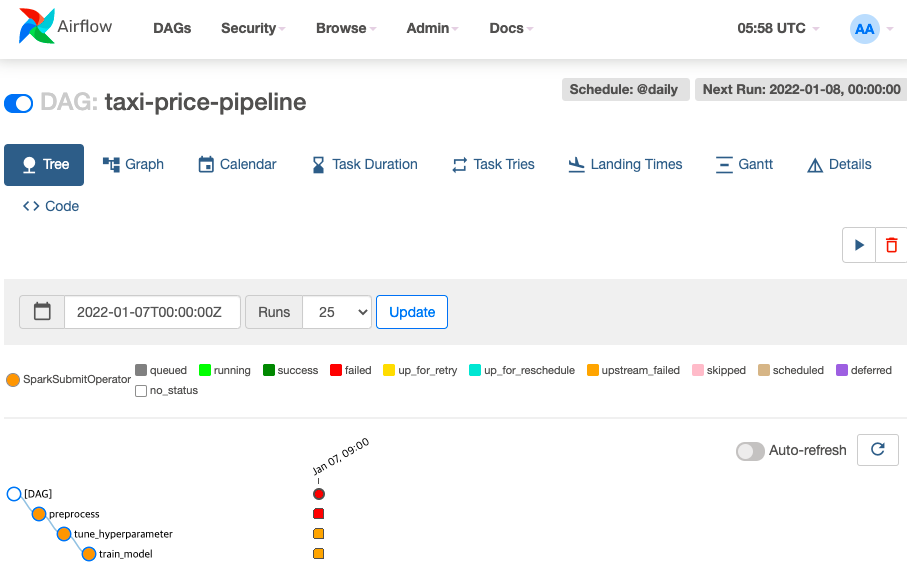

log를 보면 airflow.exceptions.AirflowException: Cannot execute라고 뜬다.
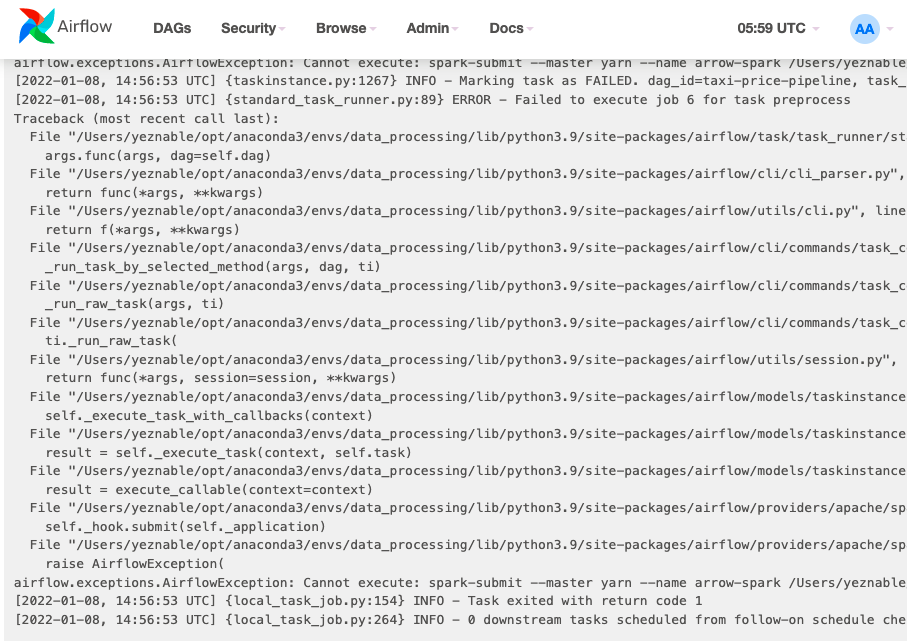

해당 에러는 dag나 Spark pipeline을 작성한 python 버전과 Airflow를 작동시키는 python의 버전이 다르면 일어날 수 있다고 한다.

--------
그래서 별의 별 짓을 다 하다가 결국 첫번째 pipeline까지 실행시키는 것에 성공했다.  
첫번째를 실행시키기 위해 다음과 같은 작업을 하였다.  

1. airflow를 uninstall하고 다시 받았다.
- !pip uninstall apache-airflow
- !pip3 install apache-airflow
- 근데 이 방법을 하면서는 메시지 변화가 많지 않았어서 이게 도움이 됐는지는 모르겠다.

2. pyspark를 실행하고 시도했다.
- !pyspark
- sprksubmit으로 submit된 코드가 돌아가기 위해서는 결국 spark가 돌아가고 있어야 한다고 생각했다.
- 테스트 삼아서 다시 spark 실행을 끄고 해봤을 때 그냥 돌아가는거 보면 SparkOperator에서 알아서 해주는 것 같다.

3. 사용할 conn_id를 정의해줬다.
- 처음부터 정의해주지 않았는지 airflow를 다시 깔면서 있던게 없어졌는지는 기억이 잘 안나지만 정의되어 있지 않아서 정의해주었다.
- 이건 없으면 안되는게 당연하다 하지만 conn_id가 없어서 에러가 일어나는거면 그렇다는 에러 메시지가 나왔을거 같기는 하다.

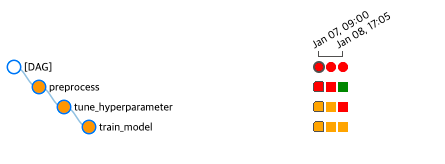

------------
근데 이렇게 한번 돼 놓고 다시 해보니 안됐다.
첫번째 pipeline에서 생성해주는 파일들을 삭제하고 돌려보면 첫번째 pipeline은 돌아가고 그 다음 실행에서는 첫번째도 안돌아간다.
이 부분은 나중에 실제로 활용할 때는 예외처리를 하여 방지해야 할 것으로 보인다.
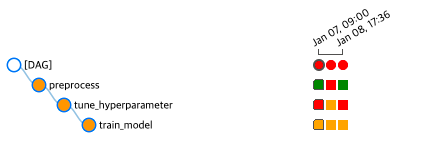

------------
두번째 pipeline이 돌아가지 않는 것은 첫번째부터 돌지 않았던 것과는 다른 에러(Task received SIGTERM signal)가 일어났다.
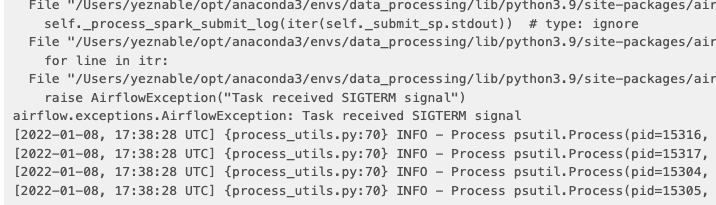

해당 에러로 검색해보니 멀티스레드 작업 중에 같은 문제가 있었어서 스레드를 통합하니 문제가 해결됐다는 글이 있었다(https://pythonq.com/so/python/602197)  

일단은 이게 airflow문제로 일어나는 일인지 pipeline 내에서 일어나는 문제인지 확인하기 위해 pipeline을 따로 실행시켜보았다.(오래 걸린다..)
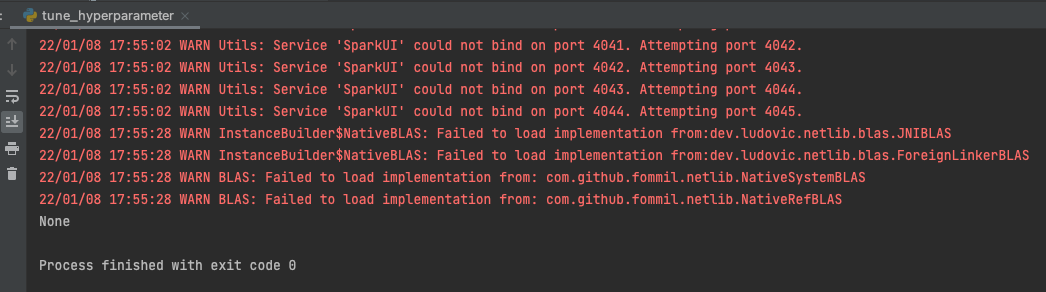

따로 실행시키니 위와 같은 출력이 나오지만 output으로 저장해야 할 파일을 저장해준다.
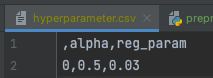

----------
다시 시도 해보니 첫번째 pipeline이 실행되었던 조건과 같은 조건에서도 Task received SIGTERM signal 에러가 일어났다.  
airflow 내부적인 멀티 스레드 방식에 맞춘 코딩이 되어있지 않아서 이거나 로컬 머신의 성능이 따라가주지 못해서 나오는 결과로 의심되기 시작한다.  
되다가 안된다는건 안되다가 될 수도 있다는 뜻으로 두어번 다시 시도해보았다.(두번째 pipeline이 ParamGrid를 활용한 hyperparameter tuning이라서 너무 오래걸려서 많이 시도하긴 어려웠다.)  

실행 중에 log를 열어보면 다음과 같이 grid의 값들을 가져와 실행하는 모습을 볼 수 있다.  
이런걸 보면 아까의 의심에 조금 더 확신을 갖게 된다.
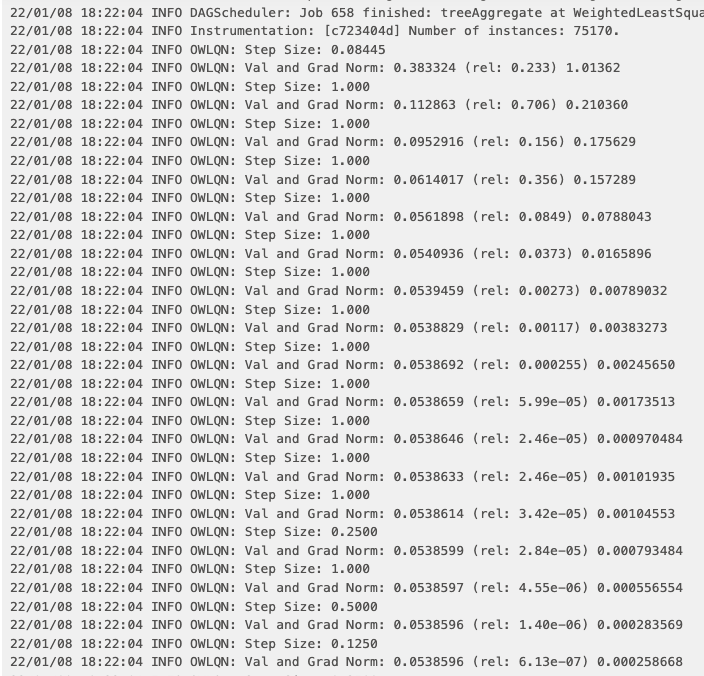

어이없게도 환경 변경 없이 여러번 해보다보니 한번은 된다..
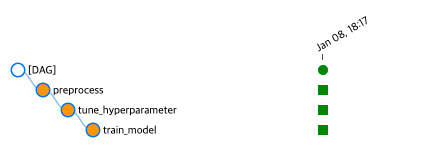

서버가 필요하다..